In [81]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
# from tqdm import tqdm
from tqdm.notebook import tqdm
from torchvision import transforms as T, datasets
from torchvision.utils import make_grid
from torchsummary import summary
import torch.nn.functional as F

import helper
import timm

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import configparser
import os

In [82]:
import importlib
importlib.reload(helper)

<module 'helper' from '/projetos/dx4o/pytorch/pneumoniaClassification/helper.py'>

dataset --> https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia<br>
reference --> https://colab.research.google.com/drive/1C5nNPj7OLYMGnNvWBU5W2zSXfgWDdXCo?usp=sharing

In [83]:
# =====================
# GET CONFIG VARIABLES
# =====================

config = configparser.ConfigParser()
config.read('config.ini')

BatchSize = config.getint('TRAIN', 'BatchSize')
Epochs = config.getint('TRAIN', 'Epochs')
LearningRate = config.getfloat('TRAIN', 'LearningRate')
model_name = config.get('TRAIN', 'ModelName')
img_size = config.getint('TRAIN', 'ImgSize')
device = config.get('TRAIN', 'Device')

DEVICE = device
MODEL_NAME = model_name
IMG_SIZE = img_size
BATCH_SIZE = BatchSize
EPOCHS = Epochs
LR = LearningRate

In [84]:
dirname = os.path.dirname("__file__")
TRAIN_PATH = os.path.join(dirname, "chest_xray", "train/")
VALID_PATH = os.path.join(dirname, "chest_xray", "val/")
TEST_PATH = os.path.join(dirname, "chest_xray", "test/")

### DATA PREPARATION

In [85]:
train_transform = T.Compose([
    T.Resize(size=(IMG_SIZE, IMG_SIZE)),
    T.RandomRotation(degrees=(-20, +20)),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = T.Compose([
    T.Resize(size=(IMG_SIZE, IMG_SIZE)),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize(size=(IMG_SIZE, IMG_SIZE)),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [86]:
trainset = datasets.ImageFolder(TRAIN_PATH, transform=train_transform)
validset = datasets.ImageFolder(VALID_PATH, transform=valid_transform)
testset = datasets.ImageFolder(TEST_PATH, transform=test_transform)

In [87]:
print(f"Trainset Size : {len(trainset)}")
print(f"Validset Size : {len(validset)}")
print(f"Testset Size : {len(testset)}")

Trainset Size : 5216
Validset Size : 16
Testset Size : 624


{'NORMAL': 0, 'PNEUMONIA': 1}


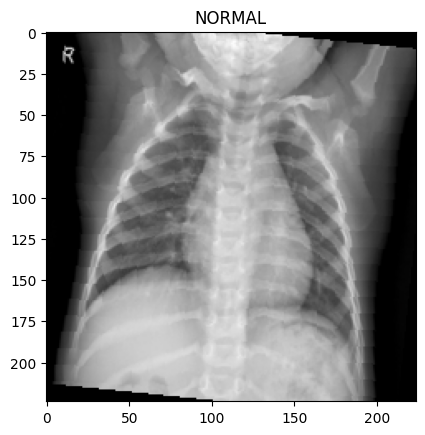

In [88]:
image, label = trainset[2]

print(trainset.class_to_idx)
class_name = ["NORMAL", "PNEUMONIA"]

helper.show_image(image, class_name[label])

### LOAD DATA INTO BATCHES

In [89]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [90]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of Total examples : {len(trainloader.dataset)}")

No. of batches in trainloader : 326
No. of Total examples : 5216


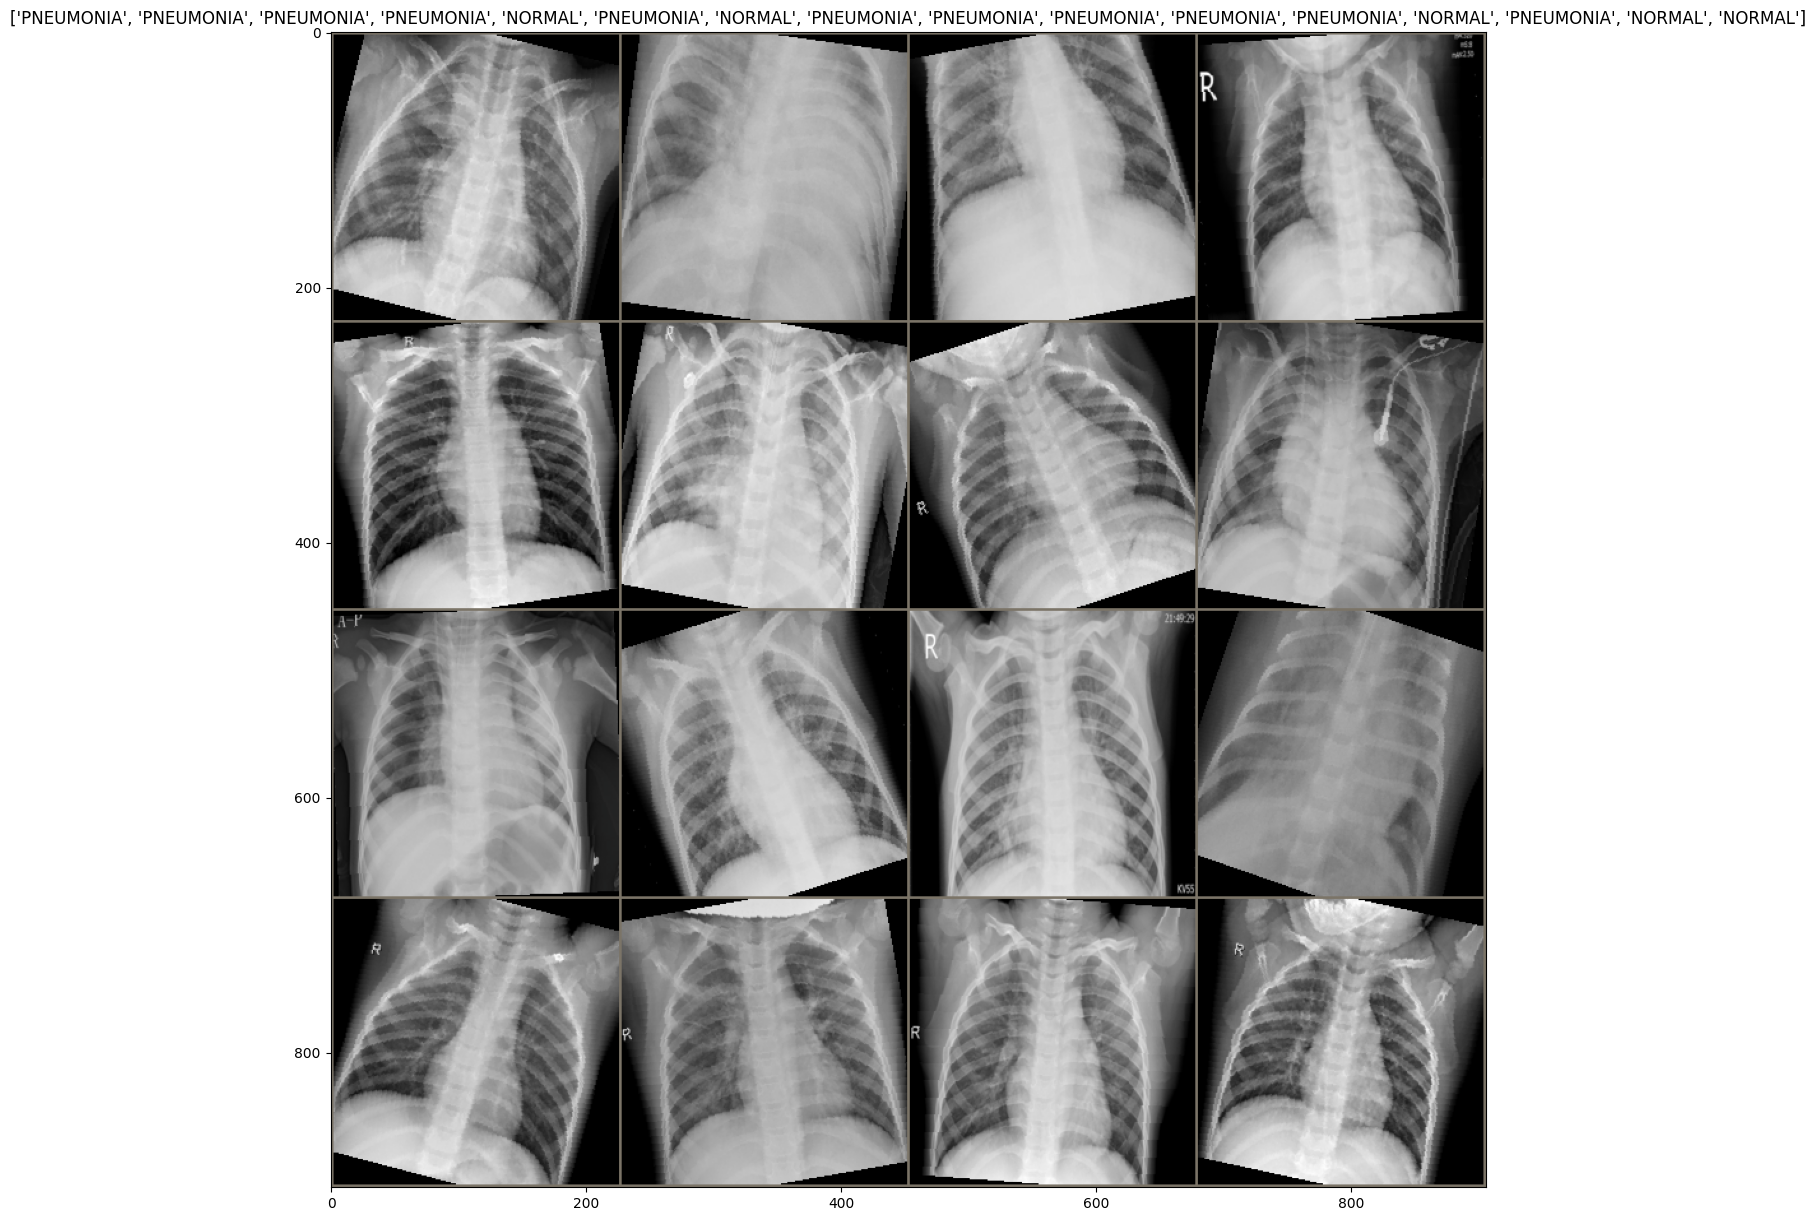

In [91]:
for images, labels in trainloader:
    break
    
out = make_grid(images, nrow=4)

class_name = ["NORMAL", "PNEUMONIA"]
helper.show_grid(out, title=[class_name[x] for x in labels])

### DEFINE MODEL

In [92]:
model = timm.create_model(MODEL_NAME, pretrained=True)
model.to(DEVICE);

In [93]:
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2)
)

In [94]:
# summary(model.to(DEVICE), input_size=(3, 224, 224), device=DEVICE)

### TRAIN MODEL

In [95]:
class PneumoniaTrainer():
    
    def __init__(self, criterion, optimizer, scheduler):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
    
    def train_batch_loop(self, model, trainloader):
        
        train_acc = 0.0
        train_loss = 0.0
        
        for images, labels in tqdm(trainloader):
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += helper.accuracy(logits, labels)
            
        avg_train_acc = train_acc / len(trainloader)
        avg_train_loss = train_loss / len(trainloader)
        
        return avg_train_acc, avg_train_loss
            
    def valid_batch_loop(self, model, validloader):
        
        valid_acc = 0.0
        valid_loss = 0.0
        
        for images, labels in tqdm(validloader):
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
                        
            valid_loss += loss.item()
            valid_acc += helper.accuracy(logits, labels)
        
        avg_valid_acc = valid_acc / len(validloader)
        avg_valid_loss = valid_loss / len(validloader)
        
        return avg_valid_acc, avg_valid_loss
    
    def fit(self, model, trainloader, validloader, epochs):
        
        model = model.to(DEVICE)
        valid_min_loss = np.Inf

        for i in range(epochs):
            
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            
            model.eval()
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            
            if avg_valid_loss < valid_min_loss:
                
                print(f"Valid loss decreased {valid_min_loss} --> {avg_valid_loss}>")
                torch.save(model.state_dict(), "LocalPneumoniaModel.pt")
                valid_min_loss = avg_valid_loss
                
            print(f"Epoch: {i+1} - Train Loss: {avg_train_loss} - Train Acc: {avg_train_acc}")
            print(f"Epoch: {i+1} - Valid Loss: {avg_valid_loss} - Valid Acc: {avg_valid_acc}")            

### TRAIN MODEL

In [96]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = None

In [97]:
trainer = PneumoniaTrainer(criterion, optimizer, scheduler)
trainer.fit(model, trainloader, validloader, EPOCHS)

  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss decreased inf --> 0.5726737976074219>
Epoch: 1 - Train Loss: 0.2964271590844985 - Train Acc: 0.8840107321739197
Epoch: 1 - Valid Loss: 0.5726737976074219 - Valid Acc: 0.6875


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2 - Train Loss: 0.21476424116344173 - Train Acc: 0.9160276055335999
Epoch: 2 - Valid Loss: 0.8300756812095642 - Valid Acc: 0.5


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss decreased 0.5726737976074219 --> 0.5079245567321777>
Epoch: 3 - Train Loss: 0.19239103958222079 - Train Acc: 0.9240797758102417
Epoch: 3 - Valid Loss: 0.5079245567321777 - Valid Acc: 0.8125


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4 - Train Loss: 0.20023587006115656 - Train Acc: 0.9217791557312012
Epoch: 4 - Valid Loss: 0.6393955945968628 - Valid Acc: 0.5


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5 - Train Loss: 0.17700523003061627 - Train Acc: 0.9305981397628784
Epoch: 5 - Valid Loss: 0.8502037525177002 - Valid Acc: 0.4375


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6 - Train Loss: 0.1711943206560164 - Train Acc: 0.9351993799209595
Epoch: 6 - Valid Loss: 0.544309675693512 - Valid Acc: 0.6875


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7 - Train Loss: 0.1806025505380168 - Train Acc: 0.9288727045059204
Epoch: 7 - Valid Loss: 0.8255709409713745 - Valid Acc: 0.5


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8 - Train Loss: 0.16981992326488296 - Train Acc: 0.9338573813438416
Epoch: 8 - Valid Loss: 0.7061485648155212 - Valid Acc: 0.5625


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9 - Train Loss: 0.18013632835168963 - Train Acc: 0.9319401979446411
Epoch: 9 - Valid Loss: 0.9364710450172424 - Valid Acc: 0.5


  0%|          | 0/326 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Valid loss decreased 0.5079245567321777 --> 0.48507729172706604>
Epoch: 10 - Train Loss: 0.15972422212190882 - Train Acc: 0.9369248747825623
Epoch: 10 - Valid Loss: 0.48507729172706604 - Valid Acc: 0.5625


### PLOT RESULTS

In [98]:
model.load_state_dict(torch.load("LocalPneumoniaModel.pt"))
model.to(DEVICE)

model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, testloader)


print(f"Test Loss : {avg_test_loss}")
print(f"Test Acc : {avg_test_acc}")

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss : 0.2936422739130182
Test Acc : 0.8717948794364929


In [71]:
model.load_state_dict(torch.load("ColabPneumoniaModel.pt"))
model.to(DEVICE)

model.eval()
avg_test_acc, avg_test_loss = trainer.valid_batch_loop(model, testloader)


print(f"Test Loss : {avg_test_loss}")
print(f"Test Acc : {avg_test_acc}")

  0%|          | 0/39 [00:00<?, ?it/s]

Test Loss : 0.29589300459394086
Test Acc : 0.879807710647583


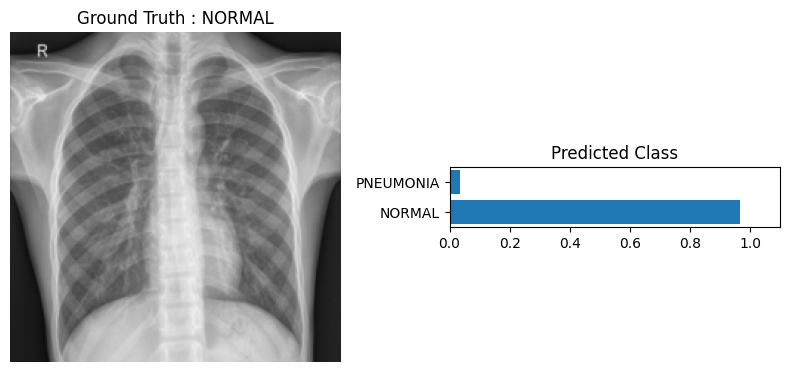

In [102]:
image, label = testset[2]

logits = model(image.to(device).unsqueeze(0)) # (3, 224, 224) -> (1, 3, 224, 224)
logits = F.softmax(logits, dim = 1)

helper.view_classify(image, logits, label)